# Differential expression validation
This notebook performs a differential expression (DE) analysis comparing PAO1 samples vs PA14 samples. We can compare our results with those published in the literature as an additional step to validate that our RNA-seq processing are reasonable.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from core_acc_modules import utils, paths
from rpy2.robjects import pandas2ri
pandas2ri.activate()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Download data for validation
Data from [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) found ~ 2K DEGs between 2 strains where QS genes were DEGs.

In [2]:
# Download sra data files
! prefetch --option-file $paths.SRA_ACC_TEST

In [3]:
%%bash
mkdir $paths.FASTQ_TEST_DIR
fastq-dump $paths.SRA_DIR/SRR8486287.sra --outdir $paths.FASTQ_TEST_DIR/
fastq-dump $paths.SRA_DIR/SRR8486288.sra --outdir $paths.FASTQ_TEST_DIR/
fastq-dump $paths.SRA_DIR/SRR8486289.sra --outdir $paths.FASTQ_TEST_DIR/
fastq-dump $paths.SRA_DIR/SRR8486290.sra --outdir $paths.FASTQ_TEST_DIR/

'%%bash\nmkdir $paths.FASTQ_TEST_DIR\nfastq-dump $paths.SRA_DIR/SRR8486287.sra --outdir $paths.FASTQ_TEST_DIR/\nfastq-dump $paths.SRA_DIR/SRR8486288.sra --outdir $paths.FASTQ_TEST_DIR/\nfastq-dump $paths.SRA_DIR/SRR8486289.sra --outdir $paths.FASTQ_TEST_DIR/\nfastq-dump $paths.SRA_DIR/SRR8486290.sra --outdir $paths.FASTQ_TEST_DIR/'

In [4]:
%%bash -s $paths.PAO1_QUANT_TEST $paths.FASTQ_TEST_DIR $paths.PAO1_INDEX
mkdir $1

for FILE_PATH in $2/*;
do

# get file name
sample_name=`basename ${FILE_PATH}`

# remove extension from file name
sample_name="${sample_name%_*}"

# get base path
base_name=${FILE_PATH%/*}

echo "Processing sample ${sample_name}"

salmon quant -i $3 -l A \
            -r ${base_name}/${sample_name} \
            -p 8 --validateMappings -o $1/${sample_name}_quant
done

Processing sample SRR8486287.fastq
Processing sample SRR8486288.fastq
Processing sample SRR8486289.fastq
Processing sample SRR8486290.fastq


mkdir: cannot create directory ‘/home/alexandra/ncbi/public/quants_pao1_test’: File exists
Version Info: This is the most recent version of salmon.
### salmon (selective-alignment-based) v1.3.0
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /home/alexandra/Documents/Data/Core_accessory/pao1_index }
### [ libType ] => { A }
### [ unmatedReads ] => { /home/alexandra/ncbi/public/fastq_test/SRR8486287.fastq }
### [ threads ] => { 8 }
### [ validateMappings ] => { }
### [ output ] => { /home/alexandra/ncbi/public/quants_pao1_test/SRR8486287.fastq_quant }
Logs will be written to /home/alexandra/ncbi/public/quants_pao1_test/SRR8486287.fastq_quant/logs
[2020-08-05 16:18:42.671] [jointLog] [info] setting maxHashResizeThreads to 8
[2020-08-05 16:18:42.671] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2020-08-05 16:18:42.671] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since 

In [5]:
# Get raw read counts using PAO1 reference
# Read through all sample subdirectories in quant/
# Within each sample subdirectory, get quant.sf file
data_dir = paths.PAO1_QUANT_TEST

expression_data = pd.DataFrame(
    pd.read_csv(file, sep="\t", index_col=0)["NumReads"].
    rename(file.parent.name.split("_")[0]) 
    for file in data_dir.rglob("*/quant.sf"))    

# Map gene ids to gene names
pao1_fasta_file = paths.PAO1_REF

seq_id_to_gene_id_pao1 = utils.dict_gene_num_to_ids(pao1_fasta_file)

expression_data.rename(mapper=seq_id_to_gene_id_pao1, axis="columns", inplace=True)

expression_data.head()

Name,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
SRR8486287.fastq,1955.0,1552.0,899.0,3043.0,263.0,128.0,839.0,1198.0,304.0,30.0,...,213.0,679.0,363.0,114.0,1118.0,4.0,262.0,1458.0,793.0,1257.0
SRR8486289.fastq,3210.0,2354.0,1041.0,5630.0,324.0,125.0,300.0,2252.0,729.0,61.0,...,363.0,1756.0,1144.0,298.0,2667.0,6.0,673.0,4574.0,1937.0,2688.0
SRR8486290.fastq,2873.0,2160.0,989.0,5805.0,293.0,109.0,387.0,1647.0,529.0,61.0,...,254.0,1481.0,941.0,221.0,1909.0,4.0,613.0,3559.0,1594.0,1759.0
SRR8486288.fastq,2129.0,1188.0,1047.0,2349.0,232.0,155.0,819.0,754.0,283.0,41.0,...,280.0,452.0,278.0,73.0,1075.0,12.0,239.0,1098.0,569.0,932.0


In [6]:
new_index = [name.split(".")[0] for name in list(expression_data.index)]
expression_data.index = new_index
expression_data.head()

Name,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
SRR8486287,1955.0,1552.0,899.0,3043.0,263.0,128.0,839.0,1198.0,304.0,30.0,...,213.0,679.0,363.0,114.0,1118.0,4.0,262.0,1458.0,793.0,1257.0
SRR8486289,3210.0,2354.0,1041.0,5630.0,324.0,125.0,300.0,2252.0,729.0,61.0,...,363.0,1756.0,1144.0,298.0,2667.0,6.0,673.0,4574.0,1937.0,2688.0
SRR8486290,2873.0,2160.0,989.0,5805.0,293.0,109.0,387.0,1647.0,529.0,61.0,...,254.0,1481.0,941.0,221.0,1909.0,4.0,613.0,3559.0,1594.0,1759.0
SRR8486288,2129.0,1188.0,1047.0,2349.0,232.0,155.0,819.0,754.0,283.0,41.0,...,280.0,452.0,278.0,73.0,1075.0,12.0,239.0,1098.0,569.0,932.0


### Process data
1. Get core genes
2. Round read counts to integer value

In [7]:
# Get mapping between PAO1 and PA14 genes using PAO1 reference
gene_annot_file = paths.GENE_PAO1_ANNOT
gene_mapping_pao1 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pao1')
gene_annot_file = paths.GENE_PA14_ANNOT
gene_mapping_pa14 = utils.get_pao1_pa14_gene_map(gene_annot_file, 'pa14')

core_pao1_genes, core_pa14_genes = utils.get_core_genes(gene_mapping_pao1,
                                                        gene_mapping_pa14,
                                                        False)
print(f"Number of PAO1 core genes: {len(core_pao1_genes)}")
print(f"Number of PA14 core genes: {len(core_pa14_genes)}")

core_pao1_genes = set(core_pao1_genes) - set(["PA4215", "PA4214","PA4213"])

expression_data = expression_data.reindex(columns=core_pao1_genes)
print(expression_data.shape)
expression_data.head()

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
(4, 5363)


Name,PA3104,PA3532,PA4345,PA1857,PA3946,PA3192,PA0236,PA0513,PA5361,PA3117,...,PA0917,PA5284,PA3916,PA4443,PA3526,PA0813,PA0620,PA2008,PA4753,PA2029
SRR8486287,513.0,24.0,428.0,199.0,155.0,1384.0,24.0,1408.0,95.0,833.0,...,603.0,23.0,89.0,216.0,345.0,52.0,1290.0,830.0,124.0,35.0
SRR8486289,1148.0,126.0,258.0,117.0,110.0,939.0,154.0,318.0,183.0,2011.0,...,865.0,14.0,117.0,1145.0,205.0,39.0,1073.0,2891.0,79.0,20.0
SRR8486290,1079.0,119.0,393.0,126.0,98.0,420.0,77.0,407.0,156.0,1730.0,...,772.0,10.0,139.0,622.0,204.0,40.0,1044.0,1996.0,109.0,34.0
SRR8486288,576.0,25.0,399.0,152.0,119.0,1164.0,22.0,1069.0,99.0,670.0,...,639.0,19.0,82.0,249.0,751.0,35.0,924.0,864.0,120.0,24.0


In [8]:
# Convert values to integers for DE analysis
# Not sure why the "Numreads" values are floats
expression_data = expression_data.astype(int)

In [9]:
# Save file
expression_data.to_csv(paths.PAO1_GE_DE, sep='\t')

### Examine gene expression
1. Look at consistency of gene expression within PAO1 samples, within PA14 samples
2. What does average PAO1 vs averge PA14 look like? To give us an expectation for our DESeq analysis.

In [10]:
expression_data = pd.read_csv(paths.PAO1_GE_DE, sep="\t", index_col=0)
expression_data.head()

,PA3104,PA3532,PA4345,PA1857,PA3946,PA3192,PA0236,PA0513,PA5361,PA3117,...,PA0917,PA5284,PA3916,PA4443,PA3526,PA0813,PA0620,PA2008,PA4753,PA2029
SRR8486287,513,24,428,199,155,1384,24,1408,95,833,...,603,23,89,216,345,52,1290,830,124,35
SRR8486289,1148,126,258,117,110,939,154,318,183,2011,...,865,14,117,1145,205,39,1073,2891,79,20
SRR8486290,1079,119,393,126,98,420,77,407,156,1730,...,772,10,139,622,204,40,1044,1996,109,34
SRR8486288,576,25,399,152,119,1164,22,1069,99,670,...,639,19,82,249,751,35,924,864,120,24


In [11]:
# Group samples as PAO1 or PA14 based on experiment metadata
sample_annot_file = paths.SAMPLE_ANNOT_TEST
pao1_ids, pa14_ids = utils.get_sample_grps(sample_annot_file)

In [12]:
# Split expression by genotype
pao1_expression = expression_data.loc[pao1_ids]
pa14_expression = expression_data.loc[pa14_ids]

In [13]:
# Get within sample correlation
pao1_corr = pao1_expression.T.corr()
pa14_corr = pa14_expression.T.corr()

Text(0.5, 1.0, 'PAO1 sample correlation')

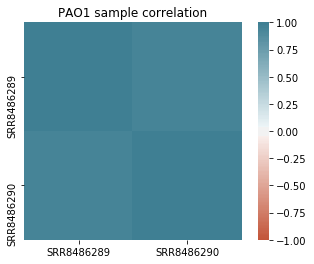

In [14]:
ax = sns.heatmap(
    pao1_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title("PAO1 sample correlation")

Text(0.5, 1.0, 'PA14 sample correlation')

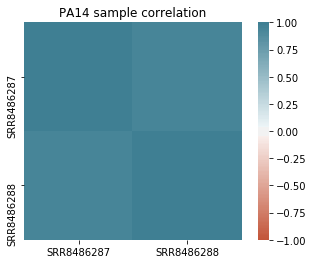

In [15]:
ax = sns.heatmap(
    pa14_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_title("PA14 sample correlation")

In [16]:
# Get mean expression for pao1 and pa14
mean_pao1 = pao1_expression.mean()
mean_pa14 = pa14_expression.mean()

pao1_v_pa14_df = pd.DataFrame(data={'pao1_mean': mean_pao1.values,
                                   'pa14_mean': mean_pa14.values},
                             index=pao1_expression.columns)

pao1_v_pa14_df.head()

,pao1_mean,pa14_mean
PA3104,1113.5,544.5
PA3532,122.5,24.5
PA4345,325.5,413.5
PA1857,121.5,175.5
PA3946,104.0,137.0


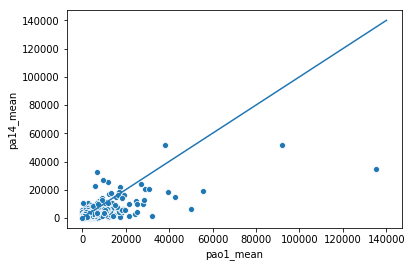

In [17]:
sns.scatterplot(data=pao1_v_pa14_df, x='pao1_mean', y='pa14_mean')
plt.plot([0,140000],[0,140000])

In [18]:
# Rough calculation of the number of genes that differ
# This is roughly what we would expect to get from the DE analysis

std_x_eq_y = np.std(abs(pao1_v_pa14_df['pao1_mean']-pao1_v_pa14_df['pa14_mean']))
gene_differences = pao1_v_pa14_df[abs(pao1_v_pa14_df['pao1_mean']-pao1_v_pa14_df['pa14_mean']) > std_x_eq_y]
print(gene_differences.shape)
genes_found_from_GE = list(gene_differences.index)
gene_differences.head()

(217, 2)


,pao1_mean,pa14_mean
PA4761,28231.0,9884.0
PA1905,5681.0,295.0
PA0998,14582.5,1861.0
PA2567,185.5,2695.0
PA1900,12094.5,472.0


**Observations:**
* Looks like there is consistent gene expression patterns within sample-type (i.e. Both PAO1 samples have a similar gene expression profile, similarly for both PA14 samples) as expected
* Comparing the mean expression of PAO1 and PA14 we see that there are ~200 genes changed. This gives us some indication about what to expect for our DESeq analysis. However, we shouldn't expect the numbers to align because we are using different methods -- above we are comparing the raw gene expression values and looking for a threshold difference; below we DESeq fits the negative binomial model to the data and performs hypothesis testing to determine if there is a difference between the groups of samples.  

### Differential expression analysis

In [19]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2")

NULL


In [20]:
%%R
# Load the DESeq2 library
library("DESeq2")

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/py

In [21]:
# Files to load into DE analysis (R)
metadata_file = str(paths.SAMPLE_ANNOT_TEST)
expression_data_file = str(paths.PAO1_GE_DE)
out_file = str(paths.DE_STATS)

In [22]:
# Check ordering of sample ids
utils.check_sample_ordering(expression_data_file, metadata_file)

sample ids don't match, going to re-order gene expression samples


In [23]:
%%R -i metadata_file -i expression_data_file -i out_file

source('../core_acc_modules/DE_analysis.R')

get_DE_stats_DESeq(metadata_file,
                   expression_data_file,
                   out_file)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/rpy2/rinterface/__init_

[1] "Checking sample ordering..."
[1] TRUE


In [24]:
# Read in DE stats file
DE_stats = pd.read_csv(paths.DE_STATS, sep='\t', header=0, index_col=0)
print(DE_stats.shape)
DE_stats.head()

(5363, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
PA3104,802.399535,0.735314,0.258507,2.844464,4.448628e-03,0.017907
PA3532,68.676224,2.029051,0.404459,5.016707,5.256455e-07,0.000007
PA4345,375.592817,-0.624424,0.306263,-2.038848,4.146523e-02,0.110820
PA1857,151.073694,-0.813021,0.315553,-2.576500,9.980607e-03,0.035025
PA3946,121.905551,-0.684616,0.326609,-2.096133,3.607035e-02,0.099123


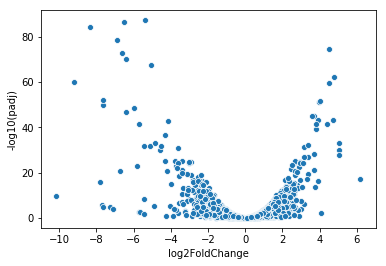

In [25]:
# Volcano plot
DE_stats["-log10(padj)"] = -np.log10(DE_stats["padj"])
sns.scatterplot(data=DE_stats, x="log2FoldChange", y="-log10(padj)")

### Compare our DE results with publication

In [26]:
# Get number of DEGs
selected_DE_stats = DE_stats[(DE_stats['padj']<0.01)]

print(selected_DE_stats.shape)
selected_DE_stats.head()

(1169, 7)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,-log10(padj)
PA3532,68.676224,2.029051,0.404459,5.016707,5.256455e-07,6.642592e-06,5.177662
PA3192,1001.984346,-1.213288,0.329953,-3.677152,2.358522e-04,1.499244e-03,2.824128
PA0236,64.066845,2.022912,0.450545,4.489920,7.124992e-06,7.161775e-05,4.144979
PA0513,843.202735,-2.049616,0.277643,-7.382187,1.557108e-13,5.684524e-12,11.245306
PA3117,1253.187312,1.026605,0.249290,4.118119,3.819767e-05,3.098845e-04,3.508800


In [27]:
# Compare our findings against Sana et. al.
degs_sana = ["PA3431", "PA3432", "PA1244", "PA4685"]
for gene in degs_sana:
    if gene in list(selected_DE_stats.index):
        print(gene)

PA3431
PA3432
PA1244
PA4685


In [28]:
# Compare genes whose mean gene expression differed between PAO1 and PA14
# with those genes found using DESeq
top_degs_by_padj = selected_DE_stats.index
len(set(top_degs_by_padj).intersection(genes_found_from_GE))/len(genes_found_from_GE)

0.7373271889400922

**Conclusions:**

Our DE analysis found ~1.1K significantly differentially expressed genes

(Check 1): The DEGs identified using DESeq (\~1.1K genes) is fairly consistent with the genes that were 1 standard deviation outside the correlation threshold (\~200 genes) -- there was a 75% overlap in these gene sets. This very roughly validates that DESeq is working as expected. I wouldn't expect the numbers to be this different though.

(Check 2) The number of DEGs identified (\~1.1K genes) using DESeq is fairly consistent with the number of differentially expressed genes found in [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) (\~2K genes). We also spot checked specific genes that were found. We found the 4 genes highlighted in the Sana et. al. publication, including the main qsIA gene (PA1244) that the paper found to be more highly expressed in PAO1 vs PA14. Difference are likely due to differences in the package used. 

Approach used in [Sana et. al](https://jb.asm.org/content/201/21/e00362-19) found ~ 2K DEGs between 2 strains where QS genes were DEGs:
```
Illumina reads were mapped to the P. aeruginosa genome PAO1 (GenBank accession number AE004091.2 [61]) and PA14 (GenBank accession number NC_008463.1 [33]) by Bowtie (version Bowtie1 v0.12.9 [62]). Data were normalized by reads per kilobase per million (RPKM) and filtered to the 5,263 orthologous genes conserved between P. aeruginosa strains PA14 and PAO1. Two biological replicates were performed per condition. Differential
expression analysis was analyzed using the Bioconductor package NOISeq version 2.22.1 (64), a nonparametric approach suitable for lowly replicated data, and using a q value of 0.99 for strong control of
false positives
```